## imports

In [1]:
try:
    import pandas as pd
    import numpy as np
    from pathlib import Path
    import json
    from matplotlib import pyplot as plt
    from tqdm import tqdm
    from sklearn.linear_model import RidgeCV
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from sklearn.linear_model import Ridge
except:
    ! pip install -r './requirements.txt'



## Constants

In [2]:
NIU = 99999999
data_pth = Path('./data/')

with open(data_pth / 'cpi99_cons.json') as fin:
    cpi99_cons = json.load(fin)

import seaborn as sns

def corr_heatmap(df):
    corr = df.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Drop useless columns

In [3]:
raw_data = pd.read_csv('./data/beginner.csv')
# simple_data = raw_data[[
#     'YEAR', 'SERIAL', 'REGION', 'NFAMS', 'PERNUM', 
#     'RACE', 'AGE', 'SEX', 'EMPSTAT', 'OCC', 'UHRSWORKT', 
#     'WKSTAT', 'JOBCERT', 'EDUC', 'INCWAGE', 'OINCWAGE']]
# simple_data.to_csv('../data/simple_data.csv', index=False)

raw_data = pd.read_csv('./data/beginner.csv')
clean_data = raw_data[(raw_data["INCWAGE"] != 99999999.0) & (raw_data["INCWAGE"] != 0.0)]
clean_data = clean_data.dropna(subset = ['INCWAGE'])
clean_data = clean_data.dropna(how = 'all', axis = 1)
clean_data = clean_data.drop(columns = ['HFLAG', 'ASECFLAG', 'MONTH', 'CPSID', 'SERIAL', 'CPSIDP'])
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11538 entries, 0 to 54733
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YEAR       11538 non-null  int64  
 1   ASECWTH    11538 non-null  float64
 2   REGION     11538 non-null  int64  
 3   STATEFIP   11538 non-null  int64  
 4   NFAMS      11538 non-null  int64  
 5   PERNUM     11538 non-null  int64  
 6   ASECWT     11538 non-null  float64
 7   AGE        11538 non-null  int64  
 8   SEX        11538 non-null  int64  
 9   RACE       11538 non-null  int64  
 10  MARST      11538 non-null  int64  
 11  BPL        11538 non-null  int64  
 12  EMPSTAT    11538 non-null  int64  
 13  OCC        11538 non-null  int64  
 14  UHRSWORKT  11538 non-null  int64  
 15  WKSTAT     11538 non-null  int64  
 16  EDUC       11538 non-null  int64  
 17  INCWAGE    11538 non-null  float64
 18  OINCWAGE   11538 non-null  float64
dtypes: float64(4), int64(15)
memory usage: 1.8 MB


In [4]:
clean_data.columns

Index(['YEAR', 'ASECWTH', 'REGION', 'STATEFIP', 'NFAMS', 'PERNUM', 'ASECWT',
       'AGE', 'SEX', 'RACE', 'MARST', 'BPL', 'EMPSTAT', 'OCC', 'UHRSWORKT',
       'WKSTAT', 'EDUC', 'INCWAGE', 'OINCWAGE'],
      dtype='object')

In [5]:
incwage = clean_data['INCWAGE']
print('total reports:', len(incwage))
print('number of 0 wage:', np.count_nonzero(incwage == 0))
print('number of N.I.U wage:', np.count_nonzero(incwage == 99999999))
print('number of ? wage:', np.count_nonzero(incwage == 99999998))
print('number of NaN wage:', np.count_nonzero(incwage.isna()))
print('number of readable wage:', np.count_nonzero((incwage > 0) & (incwage < 99999998)))


total reports: 11538
number of 0 wage: 0
number of N.I.U wage: 0
number of ? wage: 0
number of NaN wage: 0
number of readable wage: 11538


In [6]:
filtered = clean_data[(clean_data['INCWAGE'] >= 0) & (clean_data['INCWAGE'] < NIU)].reset_index(drop=True)
filtered_nonzero = filtered[filtered['INCWAGE'] > 0].reset_index(drop=True)

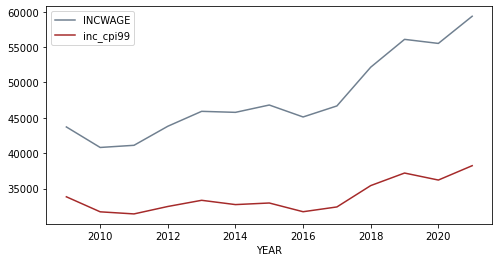

In [7]:
def clean_wage(df):
    # df['OINCWAGE'] = df['OINCWAGE'].replace(np.nan, 0).replace(99999999, 0).replace(99999998, 0)
    # df['inc_salary'] = df['INCWAGE'] - df['OINCWAGE']
    plt.rcParams["figure.figsize"] = (8,4)
    df['cpi99'] = df['YEAR'].apply(lambda yr : cpi99_cons[str(yr)])
    df['inc_cpi99'] = df['INCWAGE'] * df['cpi99']

    df.groupby('YEAR').mean()['INCWAGE'].plot(legend=True, color='slategrey')
    df.groupby('YEAR').mean()['inc_cpi99'].plot(legend=True, color='brown')

# clean_wage(filtered_nonzero)
clean_wage(filtered)
# plt.savefig('incwage_cpi99.png')


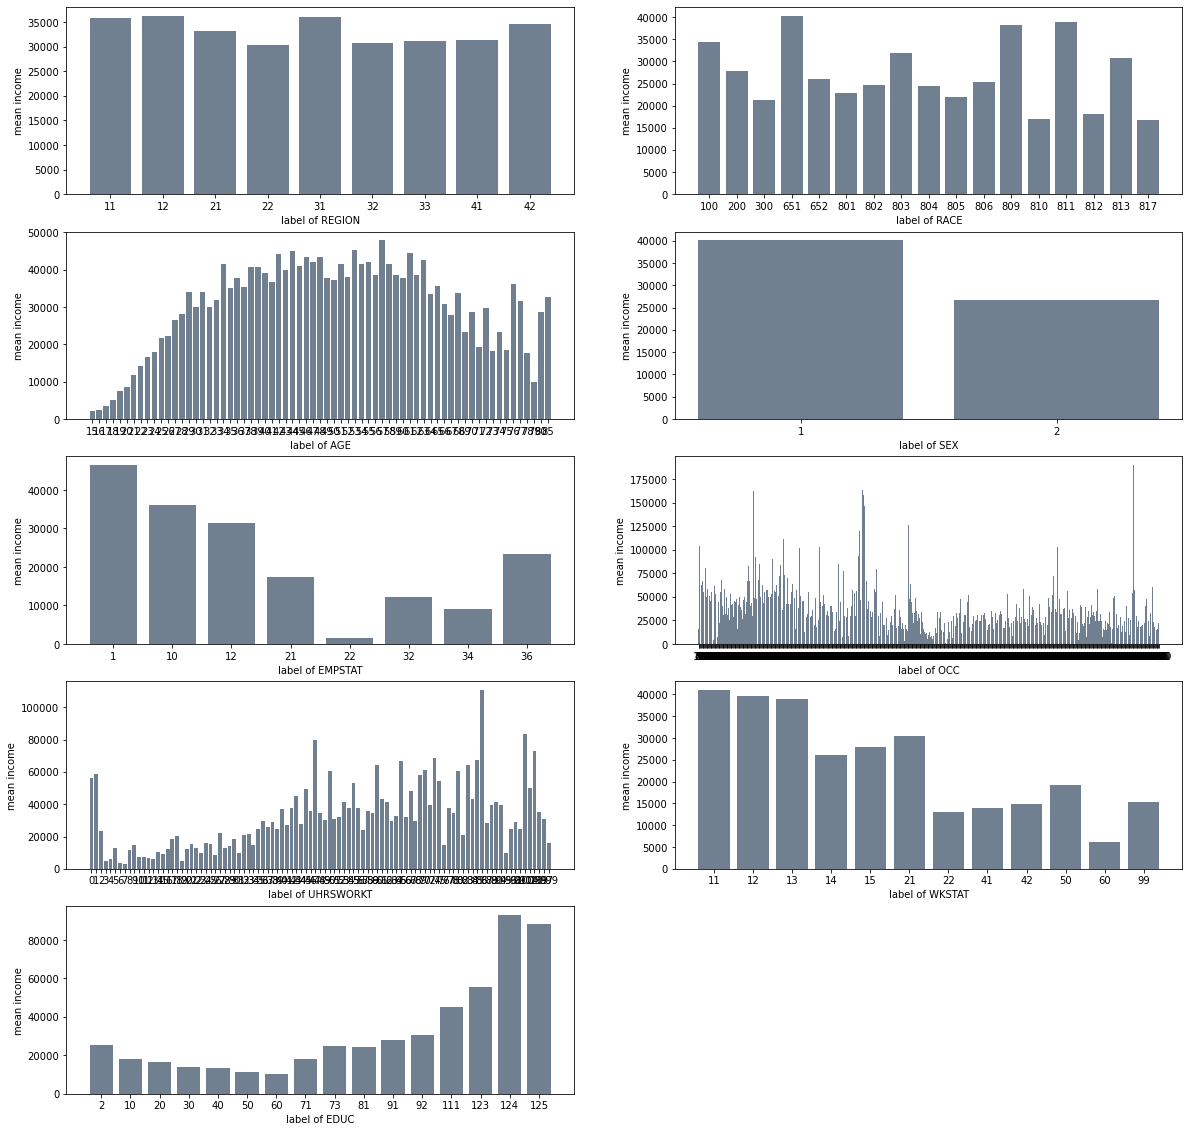

In [8]:
def display_categ(df, indices):
    
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=False)
    axs[-1, -1].axis('off')

    for i in range(len(indices)):
        ax = axs.flat[i]
        it = indices[i]
        ser = df.groupby(it).mean()['inc_cpi99']
        ax.bar(list(map(str, ser.index)), ser.values.tolist(), color='slategrey')
        
        ax.set_ylabel("mean income")
        ax.set_xlabel(f"label of {it}")
    
    return fig, axs

fig, axs = display_categ(
    filtered,
    ['REGION', 'RACE', 'AGE', 'SEX', 'EMPSTAT', 'OCC', 'UHRSWORKT', 'WKSTAT', 'EDUC'])
# fig.savefig('factors_vs_inc.png')

In [9]:
ser = filtered.groupby('REGION').mean()['inc_cpi99'].sort_values()
region_ord = ser.reset_index()['REGION']
region_ord = {region_ord.loc[i] : i  for i in region_ord.index}
filtered['region_ord'] = filtered['REGION'].apply(lambda x : region_ord[x])

ser = filtered.groupby('RACE').mean()['inc_cpi99'].sort_values()
race_ord = ser.reset_index()['RACE']
race_ord = {race_ord.loc[i] : i  for i in race_ord.index}
filtered['race_ord'] = filtered['RACE'].apply(lambda x : race_ord[x])

ser = filtered.groupby('OCC').mean()['inc_cpi99'].sort_values()
occ_ord = ser.reset_index()['OCC']
occ_ord = {occ_ord.loc[i] : i  for i in occ_ord.index}
filtered['occ_ord'] = filtered['OCC'].apply(lambda x : occ_ord[x])

# fig, axs = display_categ(
#     filtered,
#     ['region_ord', 'race_ord', 'occ_ord'])
# fig.savefig('factors_vs_inc_ord.png')

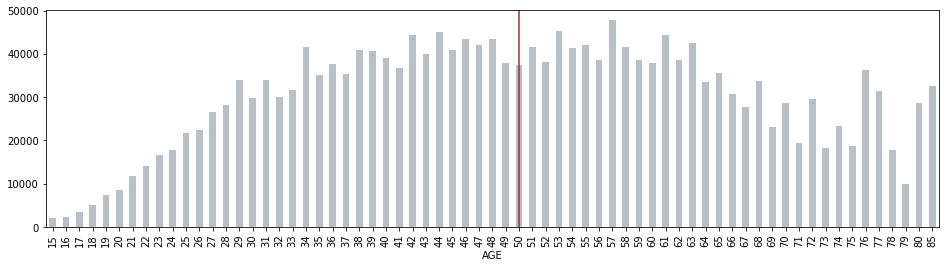

In [10]:
def age_score(df):
    plt.rcParams["figure.figsize"] = (16,4)

    mean_inc_by_age = df.groupby('AGE').mean()['inc_cpi99']
    mean_inc_by_age.plot(kind='bar', color='slategrey', alpha=.5)
    
    age_lst = mean_inc_by_age.index.tolist()

    l = np.min(age_lst)
    r = np.max(age_lst)
    while l <= r:
        mid = (l + r) >> 1
        lower = mean_inc_by_age.iloc[:mid].sum()
        upper = mean_inc_by_age.iloc[mid:].sum()
        if lower >= upper:
            r = mid - 1
        else:
            l = mid + 1
    
    plt.axvline(r, color='brown')
    plt.savefig('age_centered.png')
age_score(filtered)
    

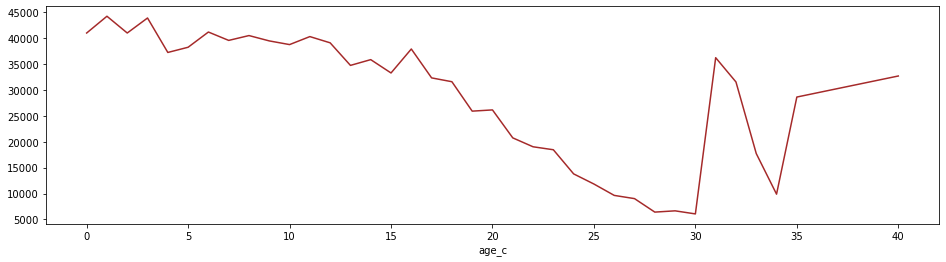

In [11]:
filtered['age_c'] = abs(filtered['AGE'] - 45)
filtered.groupby('age_c').mean()['inc_cpi99'].plot(color='brown')
plt.savefig('age_centered_plot.png')
# corr_heatmap(filtered)

## Linear Regression using reordered columns

In [12]:
def least_squares_regression(X, y):
    """ Find the least squares regression plane using the normal equations """
    return np.linalg.solve(X.T @ X, X.T @ y)
    
def mse_with_vars(df, ob, vars, f=None) :    
    data = df.get(vars).values.tolist()

    design_mat = np.array([[1, *row] for row in data])
    observ_vec = np.array(df[ob].values)

    w = least_squares_regression(design_mat, observ_vec)

    err_vec = observ_vec - design_mat @ w
    mse = np.dot(err_vec, err_vec) / len(data)

    return w, mse

In [13]:
mse_with_vars(
    filtered, 'inc_cpi99',
    ['region_ord', 'race_ord', 'age_c', 'SEX', 'EMPSTAT', 'occ_ord', 'UHRSWORKT', 'WKSTAT', 'EDUC']
)

(array([-1.08084320e+03,  4.63162504e+02,  5.34346790e+02, -4.83704081e+02,
        -9.45127047e+03,  1.71483767e+02,  8.35795210e+01,  2.42422283e-01,
        -1.01936065e+02,  2.73525381e+02]),
 1310595669.4413888)

## sklearn linear algebra

In [14]:
model_data = clean_data[['EDUC', 'AGE', 'WKSTAT']].astype(str)
model_data = pd.get_dummies(data = model_data)

X = model_data.to_numpy()
y = clean_data['INCWAGE'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

model = LinearRegression(normalize = True)
model.fit(X_train, y_train) 
weight = model.coef_
bias = model.intercept_
X_predict = model.predict(X_test)
model_error = mean_squared_error(y_test, X_predict)
model.score(X_test, y_test), model_error

clf = RidgeCV(alphas=[1e-3]).fit(X_train, y_train)
clf.score(X_test, y_test), model_error

(0.19164925333059746, 2522969198.516464)

## sklearn Ridge Regression

In [15]:
raw_data = pd.read_csv('./data/beginner.csv')
clean_data = raw_data[(raw_data["INCWAGE"] != 99999999.0) & (raw_data["INCWAGE"] != 0.0)]
clean_data = clean_data.dropna(subset = ['INCWAGE'])
clean_data = clean_data.dropna(how = 'all', axis = 1)
clean_data = clean_data.drop(columns = ['HFLAG', 'ASECFLAG', 'MONTH', 'CPSID', 'SERIAL', 'CPSIDP'])
q_low = clean_data["INCWAGE"].quantile(0.01)
q_hi  = clean_data["INCWAGE"].quantile(0.99)
clean_data = clean_data[(clean_data["INCWAGE"] < q_hi) & (clean_data["INCWAGE"] > q_low)]
clean_data
lst = ['WKSTAT', 'MARST', 'OCC', 'SEX', 'EMPSTAT', 'PERNUM', 'UHRSWORKT', 'AGE', 'EDUC']
corr = clean_data.corr()['INCWAGE'].sort_values()      
def encode(col):
    series = clean_data.groupby(col).median()['INCWAGE'].sort_values()
    log = {}
    for idx in series.index:
        log[idx] = int(series[idx])
    clean_data[col] = clean_data[col].replace(log)
for cols in lst:
    encode(cols)
model_data = clean_data[lst]

In [16]:
X = model_data.to_numpy()
y = clean_data['INCWAGE'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
rng = np.random.RandomState(0)
clf = Ridge(alpha = 0.01)
clf.fit(X_train, y_train)
model_err = mean_squared_error(clf.predict(X_test), y_test)
clf.score(X_test, y_test), model_err

(0.48600325169519576, 677191609.0338522)